In [25]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import statsmodels.formula.api as smf # type: ignore
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif # type: ignore
from stargazer.stargazer import Stargazer # type: ignore
from scipy.stats import shapiro, bartlett
from statsmodels.stats.stattools import durbin_watson

from IPython.display import display, HTML # type: ignore
pd.set_option('display.max_columns', None)


In [2]:
# Bring in the data
df = pd.read_csv('../data/HuntersGreenHomeSales_prepped.csv')

# Have a peak
df.head()


,slnoskm,Status,Address,Street_only,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,spa,subdivn,adom,cdom_cumuldaysmls,listprice,lppersqft,PendingDate,pd_dom,pd_moy,pd_year,sppersqft,datesold,ds_dom,ds_moy,ds_year,splsale,splsal_Auction,splsal_shortsale,BankOwnedREO,pricesold,days_on_market
0,1,Sold,17711 ESPRIT DR,ESPRIT DR,28.127921,-82.340184,3,2,0,2,1695,2.0,0,0,0,1,0,0,0,8694,1992,1,0,0,NaN,HUNTERS GREEN PH 1B 02,2,2,150000,88.50,7/12/2017,12,7,2017,83.48,10/6/2018,6,10,2018,Short Sale,0,1,0,141500,451
1,2,Sold,17769 ESPRIT DR,ESPRIT DR,28.130015,-82.339863,2,2,0,2,1305,2.0,0,0,0,1,0,0,0,6540,1992,0,0,1,NaN,HUNTERS GREEN PH 1A,133,133,179000,137.16,7/2/2015,2,7,2015,122.61,7/30/2015,30,7,2015,NaN,0,0,0,160000,28
2,3,Sold,17622 ESPRIT DR,ESPRIT DR,28.129953,-82.341055,3,2,0,2,1420,2.0,0,0,0,1,0,0,0,4845,1991,1,0,0,NaN,HUNTERS GREEN PRCL 17B PH 1A,4,4,165000,116.20,6/17/2015,17,6,2015,113.73,7/29/2015,29,7,2015,NaN,0,0,0,161500,42
3,4,Sold,18111 ASHTON PARK WAY,ASHTON PARK WAY,28.138067,-82.333513,3,2,0,2,1598,2.0,0,0,0,1,0,0,0,5750,1996,1,0,0,NaN,HUNTERS GREEN,44,44,184000,115.14,6/24/2016,24,6,2016,106.38,7/29/2016,29,7,2016,NaN,0,0,0,170000,35
4,5,Sold,9203 CELEBRATION CT,CELEBRATION CT,28.129131,-82.340659,4,2,1,3,2302,2.0,0,0,0,1,0,0,0,5390,1992,0,1,0,NaN,HUNTERS GREEN PH 1B 02,14,14,180000,78.19,8/10/2015,10,8,2015,73.85,9/30/2016,30,9,2016,Short Sale,0,1,0,170000,417


In [3]:
# show me null data
df.isnull().sum()

slnoskm                0
Status                 0
Address                0
Street_only            0
lat                    0
long                   0
Beds                   0
bathsfull              0
bathshalf              0
bathstotal             0
sqft                   0
garages                4
roof_Built-Up          0
roof_Concrete          0
roof_Shake             0
roof_Shingle           0
roof_Slate             0
roof_Tile              0
roof_Other             0
lotsqft                0
yrblt                  0
pool_Community         0
pool_Private           0
pool_None              0
spa                  313
subdivn                0
adom                   0
cdom_cumuldaysmls      0
listprice              0
lppersqft              0
PendingDate            0
pd_dom                 0
pd_moy                 0
pd_year                0
sppersqft              0
datesold               0
ds_dom                 0
ds_moy                 0
ds_year                0
splsale              453


Let's drop the spa and splsale columns before we drop null rows so we don't lose a ton of data.  splsale has been recaptured by breakout columns.

In [4]:
df = df.drop(['spa', 'splsale'], axis=1)
df = df.dropna()

In [5]:
df.describe()

,slnoskm,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,adom,cdom_cumuldaysmls,listprice,lppersqft,pd_dom,pd_moy,pd_year,sppersqft,ds_dom,ds_moy,ds_year,splsal_Auction,splsal_shortsale,BankOwnedREO,pricesold,days_on_market
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000
mean,241.834728,28.131651,-82.342580,3.864017,2.656904,0.341004,2.997908,2639.857741,2.493724,0.002092,0.002092,0.002092,0.495816,0.004184,0.500000,0.002092,10937.211297,1994.127615,0.294979,0.707113,0.169456,61.456067,71.809623,3.567902e+05,132.708577,15.579498,6.135983,2016.930962,129.312594,17.543933,6.675732,2016.995816,0.006276,0.016736,0.041841,3.466532e+05,42.104603
std,139.491364,0.004647,0.008928,0.703631,0.687919,0.496141,0.830496,827.257195,0.552261,0.045739,0.045739,0.045739,0.500506,0.064617,0.500524,0.045739,6347.880281,2.580858,0.456511,0.455564,0.375547,80.380705,94.172215,1.641413e+05,21.930358,8.738992,3.117598,1.375681,21.024089,9.243342,3.106340,1.364411,0.079056,0.128416,0.200435,1.523696e+05,32.869055
min,1.000000,28.120558,-82.361649,2.000000,2.000000,0.000000,2.000000,1305.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1989.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,74.920000,1.000000,1.000000,2015.000000,73.850000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,1.415000e+05,0.000000
25%,121.250000,28.128696,-82.349495,3.000000,2.000000,0.000000,3.000000,2079.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7150.000000,1992.000000,0.000000,0.000000,0.000000,10.000000,11.000000,2.500000e+05,118.765000,8.000000,4.000000,2016.000000,114.962500,10.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,2.479250e+05,30.000000
50%,242.500000,28.130965,-82.340279,4.000000,3.000000,0.000000,3.000000,2529.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,9677.500000,1994.000000,0.000000,1.000000,0.000000,34.000000,39.000000,3.300000e+05,132.790000,15.000000,6.000000,2017.000000,129.595000,17.500000,7.000000,2017.000000,0.000000,0.000000,0.000000,3.277500e+05,38.000000
75%,361.750000,28.134790,-82.335950,4.000000,3.000000,1.000000,3.000000,3009.500000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,12431.500000,1996.000000,1.000000,1.000000,0.000000,78.000000,93.000000,4.000000e+05,144.700000,23.000000,8.000000,2018.000000,142.227500,26.000000,9.000000,2018.000000,0.000000,0.000000,0.000000,3.965000e+05,48.000000
max,482.000000,28.141323,-82.327339,6.000000,6.000000,2.000000,8.000000,8398.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52438.000000,2006.000000,1.000000,1.000000,1.000000,633.000000,674.000000,1.695000e+06,248.290000,31.000000,12.000000,2019.000000,218.160000,31.000000,12.000000,2020.000000,1.000000,1.000000,1.000000,1.435000e+06,451.000000


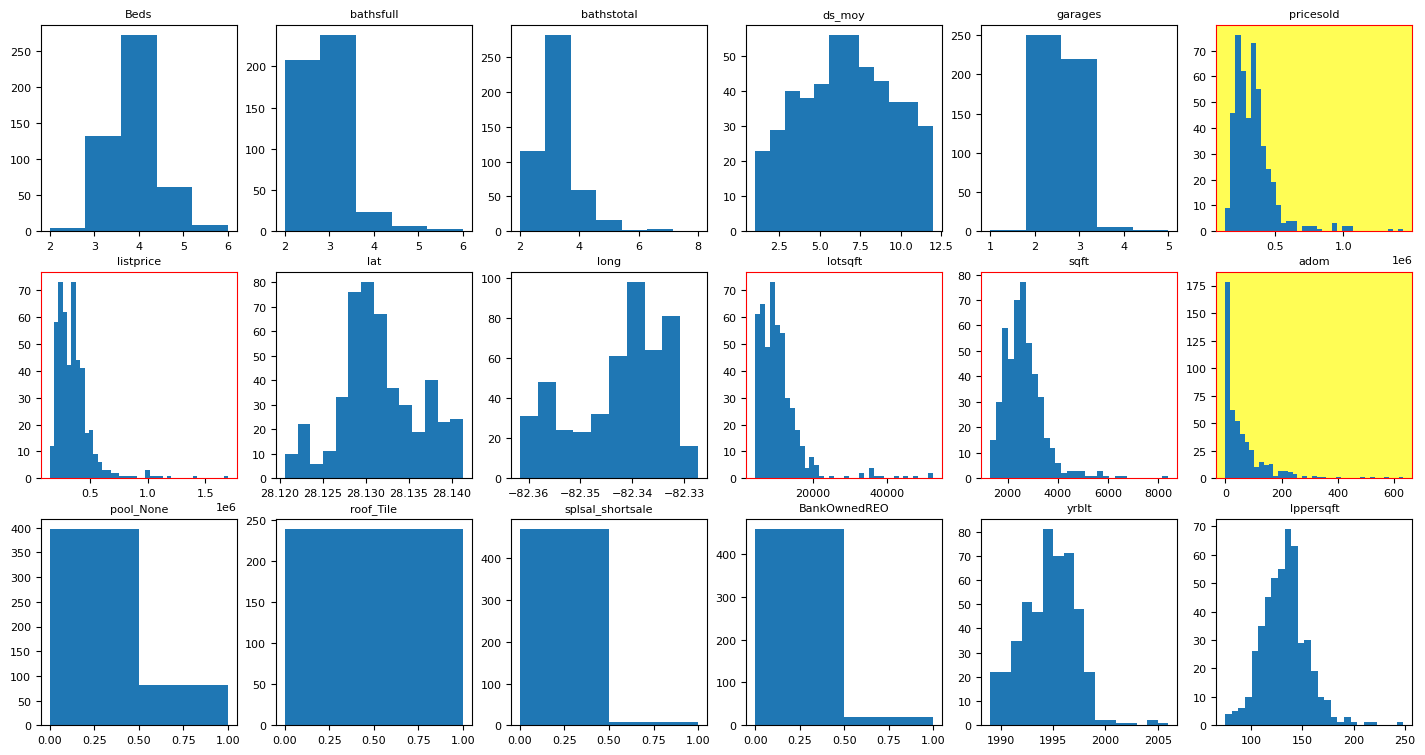

In [6]:
# histograms
plt.rcParams.update({'font.size': 8})
fig, ((Beds, bathsfull, bathstotal, ds_moy, garages, pricesold),
      (listprice, lat, long, lotsqft, sqft, adom),
      (pool_None, roof_Tile, splsal_shortsale, BankOwnedREO, yrblt, lppersqft)) = plt.subplots(nrows=3, ncols=6)

Beds.hist(df['Beds'], 5)
Beds.set_title('Beds', fontsize=8)
bathsfull.hist(df['bathsfull'], 5)
bathsfull.set_title('bathsfull', fontsize=8)
bathstotal.hist(df['bathstotal'], 7)
bathstotal.set_title('bathstotal', fontsize=8)
ds_moy.hist(df['ds_moy'], 12)
ds_moy.set_title('ds_moy', fontsize=8)
garages.hist(df['garages'],5)
garages.set_title('garages', fontsize=8)
pricesold.hist(df['pricesold'], 'auto')
pricesold.set_title('pricesold', fontsize=8)
listprice.hist(df['listprice'], 'auto')
listprice.set_title('listprice', fontsize=8)
lat.hist(df['lat'], 'auto')
lat.set_title('lat', fontsize=8)
long.hist(df['long'], 'auto')
long.set_title('long', fontsize=8)
adom.hist(df['adom'], 'auto')
adom.set_title('adom', fontsize=8)
lotsqft.hist(df['lotsqft'], 'auto')
lotsqft.set_title('lotsqft', fontsize=8)
sqft.hist(df['sqft'], 'auto')
sqft.set_title('sqft', fontsize=8)
pool_None.hist(df['pool_None'], 2)
pool_None.set_title('pool_None', fontsize=8)
roof_Tile.hist(df['roof_Tile'], 2)
roof_Tile.set_title('roof_Tile', fontsize=8)
splsal_shortsale.hist(df['splsal_shortsale'], 2)
splsal_shortsale.set_title('splsal_shortsale', fontsize=8)
BankOwnedREO.hist(df['BankOwnedREO'], 2)
BankOwnedREO.set_title('BankOwnedREO', fontsize=8)
yrblt.hist(df['yrblt'], 'auto')
yrblt.set_title('yrblt', fontsize=8)
lppersqft.hist(df['lppersqft'], 'auto')
lppersqft.set_title('lppersqft', fontsize=8)

pricesold.set_facecolor('#FFFD55')
pricesold.spines['top'].set_color('red')
pricesold.spines['right'].set_color('red')
pricesold.spines['bottom'].set_color('red')
pricesold.spines['left'].set_color('red')
adom.set_facecolor('#FFFD55')
adom.spines['top'].set_color('red')
adom.spines['right'].set_color('red')
adom.spines['bottom'].set_color('red')
adom.spines['left'].set_color('red')
sqft.spines['top'].set_color('red')
sqft.spines['right'].set_color('red')
sqft.spines['bottom'].set_color('red')
sqft.spines['left'].set_color('red')
lotsqft.spines['top'].set_color('red')
lotsqft.spines['right'].set_color('red')
lotsqft.spines['bottom'].set_color('red')
lotsqft.spines['left'].set_color('red')
listprice.spines['top'].set_color('red')
listprice.spines['right'].set_color('red')
listprice.spines['bottom'].set_color('red')
listprice.spines['left'].set_color('red')
fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

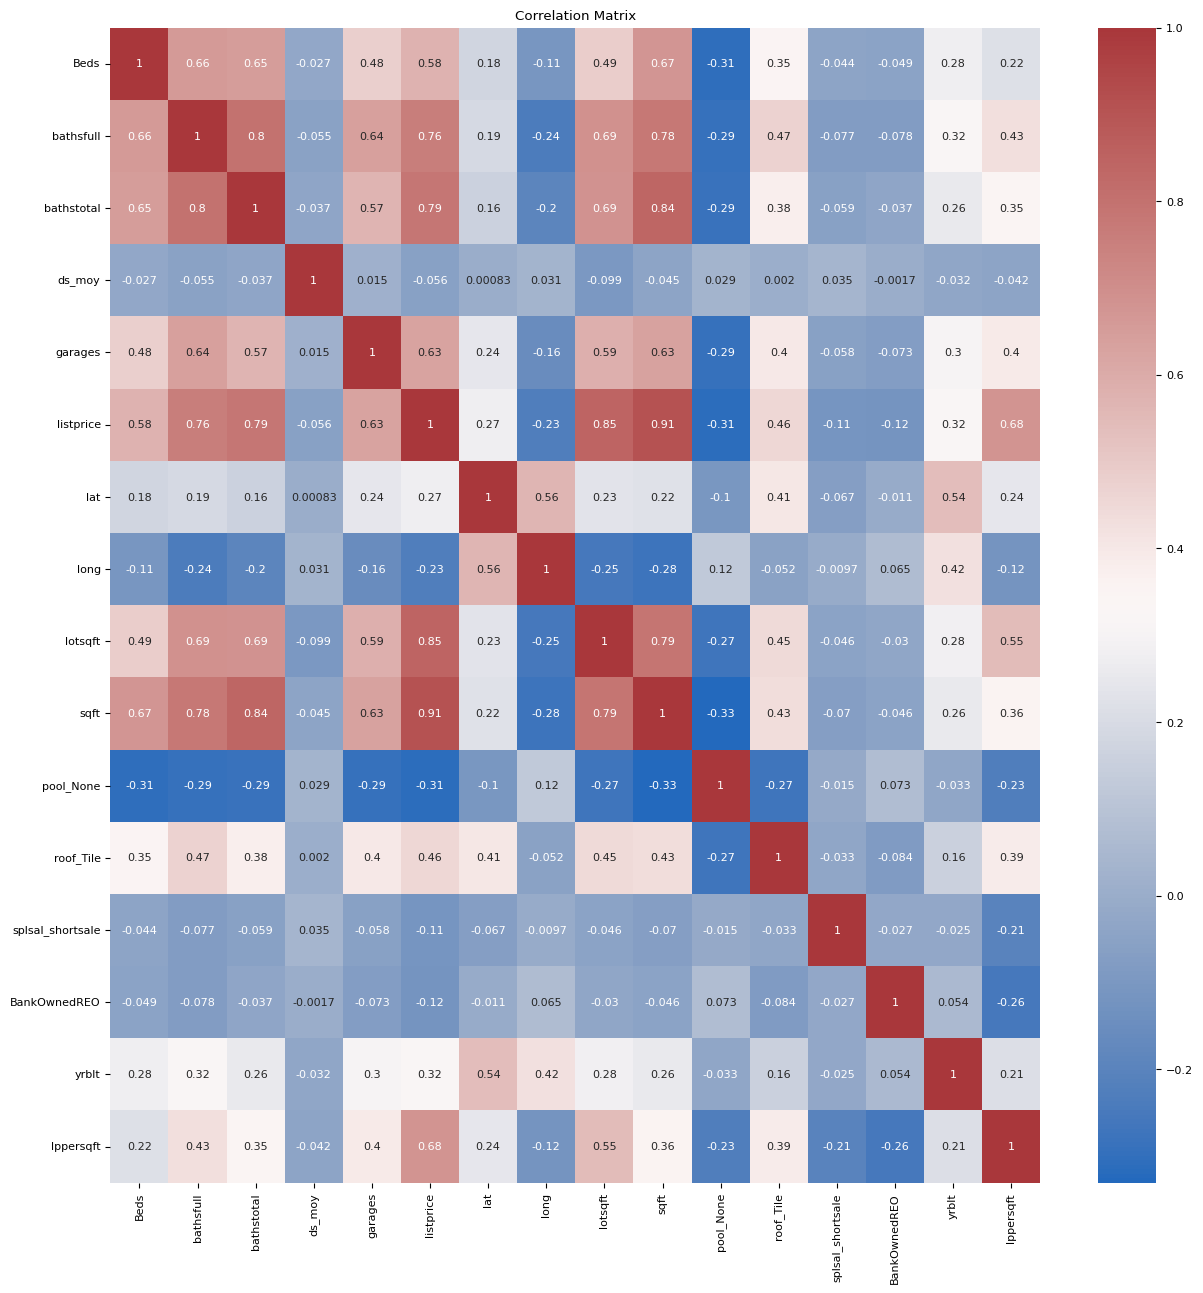

In [7]:
df_corr = df[['Beds', 'bathsfull', 'bathstotal', 'ds_moy', 'garages',
      'listprice', 'lat', 'long', 'lotsqft', 'sqft', 'pool_None', 'roof_Tile',
      'splsal_shortsale', 'BankOwnedREO', 'yrblt', 'lppersqft']]

plt.figure(figsize=(15,15))
sns.heatmap(df_corr.corr(), annot=True, cmap='vlag')

plt.title('Correlation Matrix')
plt.show()

In [8]:
# let's transform
df['log_sqft'] = np.log1p(df['sqft'])
df['house_age'] = df['pd_year'] - df['yrblt']
df['log_pricesold'] = np.log1p(df['pricesold'])
df['log_listprice'] = np.log1p(df['listprice'])
df['log_lotsqft'] = np.log1p(df['lotsqft'])
df['log_adom'] = np.log1p(df['adom'])
df.describe()
# df.head()

,slnoskm,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,adom,cdom_cumuldaysmls,listprice,lppersqft,pd_dom,pd_moy,pd_year,sppersqft,ds_dom,ds_moy,ds_year,splsal_Auction,splsal_shortsale,BankOwnedREO,pricesold,days_on_market,log_sqft,house_age,log_pricesold,log_listprice,log_lotsqft,log_adom
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,241.834728,28.131651,-82.342580,3.864017,2.656904,0.341004,2.997908,2639.857741,2.493724,0.002092,0.002092,0.002092,0.495816,0.004184,0.500000,0.002092,10937.211297,1994.127615,0.294979,0.707113,0.169456,61.456067,71.809623,3.567902e+05,132.708577,15.579498,6.135983,2016.930962,129.312594,17.543933,6.675732,2016.995816,0.006276,0.016736,0.041841,3.466532e+05,42.104603,7.837274,22.803347,12.685689,12.711512,9.190761,3.363425
std,139.491364,0.004647,0.008928,0.703631,0.687919,0.496141,0.830496,827.257195,0.552261,0.045739,0.045739,0.045739,0.500506,0.064617,0.500524,0.045739,6347.880281,2.580858,0.456511,0.455564,0.375547,80.380705,94.172215,1.641413e+05,21.930358,8.738992,3.117598,1.375681,21.024089,9.243342,3.106340,1.364411,0.079056,0.128416,0.200435,1.523696e+05,32.869055,0.281985,2.990381,0.357307,0.361914,0.438676,1.386967
min,1.000000,28.120558,-82.361649,2.000000,2.000000,0.000000,2.000000,1305.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1989.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,74.920000,1.000000,1.000000,2015.000000,73.850000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,1.415000e+05,0.000000,7.174724,12.000000,11.860062,11.918397,8.412055,0.000000
25%,121.250000,28.128696,-82.349495,3.000000,2.000000,0.000000,3.000000,2079.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7150.000000,1992.000000,0.000000,0.000000,0.000000,10.000000,11.000000,2.500000e+05,118.765000,8.000000,4.000000,2016.000000,114.962500,10.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,2.479250e+05,30.000000,7.640123,21.000000,12.420886,12.429220,8.875007,2.397895
50%,242.500000,28.130965,-82.340279,4.000000,3.000000,0.000000,3.000000,2529.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,9677.500000,1994.000000,0.000000,1.000000,0.000000,34.000000,39.000000,3.300000e+05,132.790000,15.000000,6.000000,2017.000000,129.595000,17.500000,7.000000,2017.000000,0.000000,0.000000,0.000000,3.277500e+05,38.000000,7.835974,23.000000,12.700009,12.706851,9.177662,3.555348
75%,361.750000,28.134790,-82.335950,4.000000,3.000000,1.000000,3.000000,3009.500000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,12431.500000,1996.000000,1.000000,1.000000,0.000000,78.000000,93.000000,4.000000e+05,144.700000,23.000000,8.000000,2018.000000,142.227500,26.000000,9.000000,2018.000000,0.000000,0.000000,0.000000,3.965000e+05,48.000000,8.009861,25.000000,12.890431,12.899222,9.428066,4.369448
max,482.000000,28.141323,-82.327339,6.000000,6.000000,2.000000,8.000000,8398.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52438.000000,2006.000000,1.000000,1.000000,1.000000,633.000000,674.000000,1.695000e+06,248.290000,31.000000,12.000000,2019.000000,218.160000,31.000000,12.000000,2020.000000,1.000000,1.000000,1.000000,1.435000e+06,451.000000,9.035868,30.000000,14.176676,14.343194,10.867406,6.452049


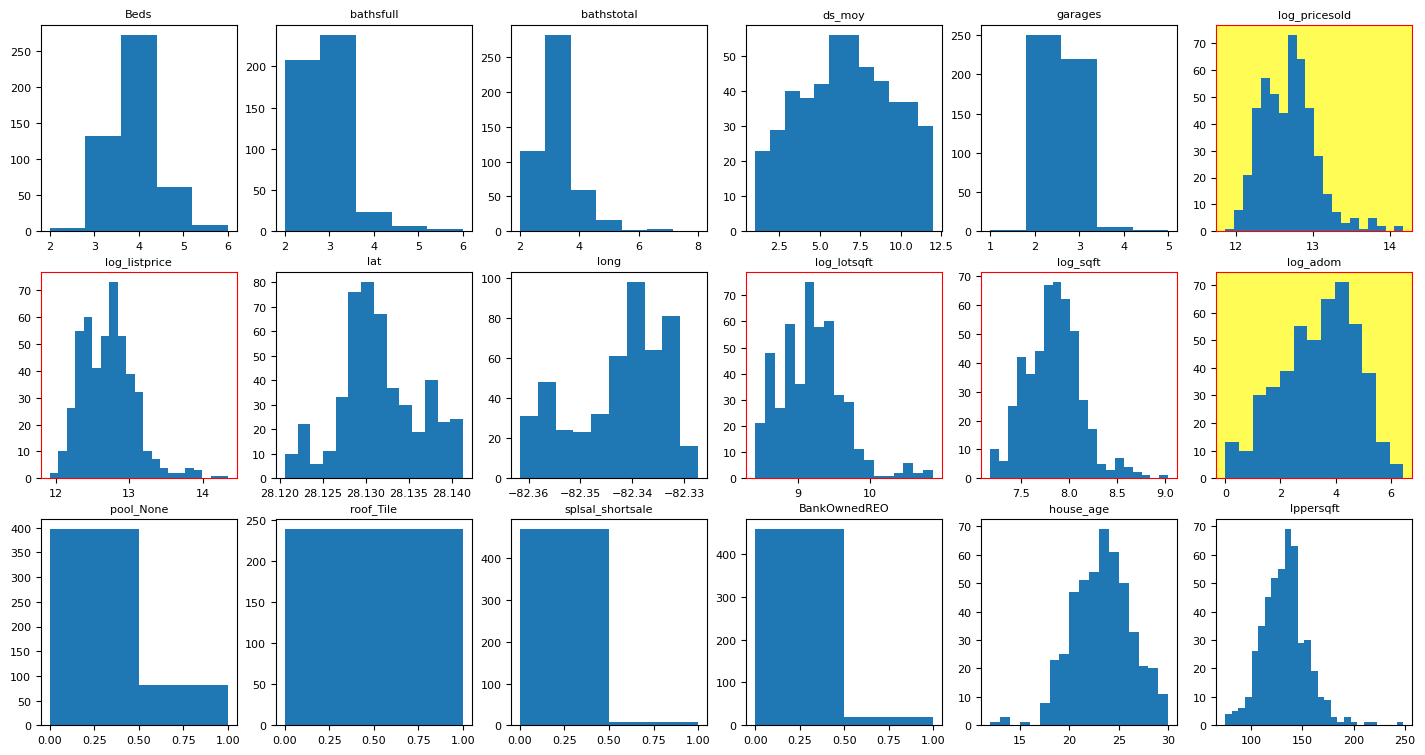

In [9]:
# updated histograms
plt.rcParams.update({'font.size': 8})
fig, ((Beds, bathsfull, bathstotal, ds_moy, garages, log_pricesold),
      (log_listprice, lat, long, log_lotsqft, log_sqft, log_adom),
      (pool_None, roof_Tile, splsal_shortsale, BankOwnedREO, house_age, lppersqft)) = plt.subplots(nrows=3, ncols=6)

Beds.hist(df['Beds'], 5)
Beds.set_title('Beds', fontsize=8)
bathsfull.hist(df['bathsfull'], 5)
bathsfull.set_title('bathsfull', fontsize=8)
bathstotal.hist(df['bathstotal'], 7)
bathstotal.set_title('bathstotal', fontsize=8)
ds_moy.hist(df['ds_moy'], 12)
ds_moy.set_title('ds_moy', fontsize=8)
garages.hist(df['garages'],5)
garages.set_title('garages', fontsize=8)
log_pricesold.hist(df['log_pricesold'], 'auto')
log_pricesold.set_title('log_pricesold', fontsize=8)
log_listprice.hist(df['log_listprice'], 'auto')
log_listprice.set_title('log_listprice', fontsize=8)
lat.hist(df['lat'], 'auto')
lat.set_title('lat', fontsize=8)
long.hist(df['long'], 'auto')
long.set_title('long', fontsize=8)
log_adom.hist(df['log_adom'], 'auto')
log_adom.set_title('log_adom', fontsize=8)
log_lotsqft.hist(df['log_lotsqft'], 'auto')
log_lotsqft.set_title('log_lotsqft', fontsize=8)
log_sqft.hist(df['log_sqft'], 'auto')
log_sqft.set_title('log_sqft', fontsize=8)
pool_None.hist(df['pool_None'], 2)
pool_None.set_title('pool_None', fontsize=8)
roof_Tile.hist(df['roof_Tile'], 2)
roof_Tile.set_title('roof_Tile', fontsize=8)
splsal_shortsale.hist(df['splsal_shortsale'], 2)
splsal_shortsale.set_title('splsal_shortsale', fontsize=8)
BankOwnedREO.hist(df['BankOwnedREO'], 2)
BankOwnedREO.set_title('BankOwnedREO', fontsize=8)
house_age.hist(df['house_age'], 'auto')
house_age.set_title('house_age', fontsize=8)
lppersqft.hist(df['lppersqft'], 'auto')
lppersqft.set_title('lppersqft', fontsize=8)

log_pricesold.set_facecolor('#FFFD55')
log_pricesold.spines['top'].set_color('red')
log_pricesold.spines['right'].set_color('red')
log_pricesold.spines['bottom'].set_color('red')
log_pricesold.spines['left'].set_color('red')
log_adom.set_facecolor('#FFFD55')
log_adom.spines['top'].set_color('red')
log_adom.spines['right'].set_color('red')
log_adom.spines['bottom'].set_color('red')
log_adom.spines['left'].set_color('red')
log_sqft.spines['top'].set_color('red')
log_sqft.spines['right'].set_color('red')
log_sqft.spines['bottom'].set_color('red')
log_sqft.spines['left'].set_color('red')
log_lotsqft.spines['top'].set_color('red')
log_lotsqft.spines['right'].set_color('red')
log_lotsqft.spines['bottom'].set_color('red')
log_lotsqft.spines['left'].set_color('red')
log_listprice.spines['top'].set_color('red')
log_listprice.spines['right'].set_color('red')
log_listprice.spines['bottom'].set_color('red')
log_listprice.spines['left'].set_color('red')
fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

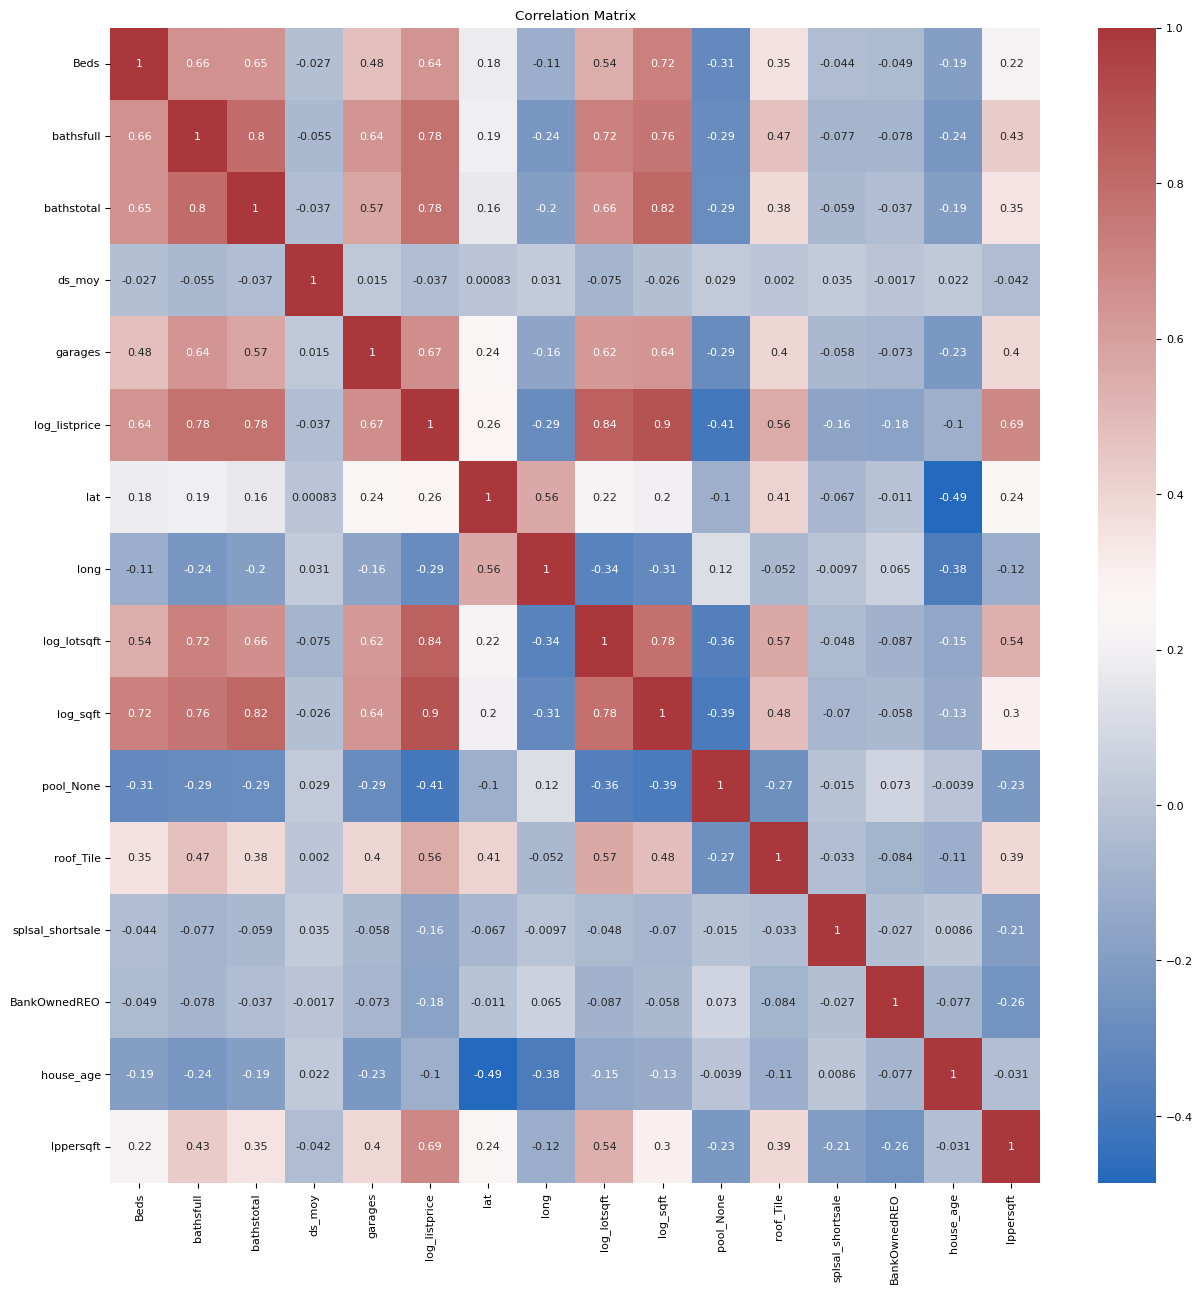

In [10]:
df_corr_t = df[['Beds', 'bathsfull', 'bathstotal', 'ds_moy', 'garages',
      'log_listprice', 'lat', 'long', 'log_lotsqft', 'log_sqft', 'pool_None', 'roof_Tile',
      'splsal_shortsale', 'BankOwnedREO', 'house_age', 'lppersqft']]
plt.figure(figsize=(15,15))
sns.heatmap(df_corr_t.corr(), annot=True, cmap='vlag')
plt.title('Correlation Matrix')
plt.show()

In [11]:
model1 = smf.ols(formula='pricesold ~ Beds + bathstotal + sqft + C(BankOwnedREO)', data=df).fit()

display(model1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesold   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     617.0
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          3.99e-186
Time:                        22:15:27   Log-Likelihood:                -5945.5
No. Observations:                 478   AIC:                         1.190e+04
Df Residuals:                     473   BIC:                         1.192e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -7.219e+04    1.6e+04     -4.510      0.000   -1.04e+05   -4.07e+04
C(BankOwnedREO)[T.1] -6.546e+04    1.4e+04     -4.663      0.000    -9.3e+04   -3.79e+04
Beds                 -1.503e+04   5521.939     -2.721      0.007   -2.59e+04   -4175.978
bathstotal            2.179e+04   6379.659      3.415      0.001    9253.087    3.43e+04
sqft                   156.9480      6.592     23.809      0.000     143.995     169.901
==============================================================================
Omnibus:                       82.822   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.789
Skew:                           0.614   Prob(JB):                     9.57e-98
Kurtosis:                       7.574   Cond. No.                     1.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
model2 = smf.ols(formula='log_pricesold ~ bathstotal + log_sqft + C(BankOwnedREO)', data=df).fit()

display(model2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_pricesold   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     714.8
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          1.90e-175
Time:                        22:15:27   Log-Likelihood:                 222.67
No. Observations:                 478   AIC:                            -437.3
Df Residuals:                     474   BIC:                            -420.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8757      0.303     16.086      0.000       4.280       5.471
C(BankOwnedREO)[T.1]    -0.2290      0.035     -6.563      0.000      -0.298      -0.160
bathstotal               0.0610      0.015      4.171      0.000       0.032       0.090
log_sqft                 0.9744      0.043     22.612      0.000       0.890       1.059
==============================================================================
Omnibus:                       25.115   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.207
Skew:                          -0.476   Prob(JB):                     1.67e-07
Kurtosis:                       3.812   Cond. No.                         372.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
model3 = smf.ols(formula='pricesold ~ long + C(pool_None) + C(roof_Tile) + house_age', data=df).fit()

display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesold   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     64.62
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.40e-43
Time:                        22:15:27   Log-Likelihood:                -6278.0
No. Observations:                 478   AIC:                         1.257e+04
Df Residuals:                     473   BIC:                         1.259e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.189e+08   5.68e+07     -7.368      0.000   -5.31e+08   -3.07e+08
C(pool_None)[T.1] -7.521e+04   1.57e+04     -4.792      0.000   -1.06e+05   -4.44e+04
C(roof_Tile)[T.1]  1.129e+05   1.18e+04      9.562      0.000    8.97e+04    1.36e+05
long              -5.094e+06   6.91e+05     -7.376      0.000   -6.45e+06   -3.74e+06
house_age         -1.329e+04   2060.409     -6.448      0.000   -1.73e+04   -9236.775
==============================================================================
Omnibus:                      298.667   Durbin-Watson:                   0.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3555.366
Skew:                           2.529   Prob(JB):                         0.00
Kurtosis:                      15.367   Cond. No.                     8.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
stargazer = Stargazer([model1, model2, model3])
html = stargazer.render_html()

display(HTML(html))

In [15]:
amodel1 = smf.ols(formula='adom ~ lppersqft + house_age + listprice', data=df).fit()

display(amodel1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   adom   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     44.04
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           4.05e-25
Time:                        22:15:28   Log-Likelihood:                -2715.9
No. Observations:                 478   AIC:                             5440.
Df Residuals:                     474   BIC:                             5456.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    219.7760     32.530      6.756      0.000     155.854     283.698
lppersqft     -1.4528      0.206     -7.054      0.000      -1.857      -1.048
house_age     -2.9660      1.127     -2.631      0.009      -5.181      -0.751
listprice      0.0003   2.81e-05     10.193      0.000       0.000       0.000
==============================================================================
Omnibus:                      180.763   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              804.408
Skew:                           1.637   Prob(JB):                    2.11e-175
Kurtosis:                       8.447   Cond. No.                     3.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
amodel2 = smf.ols(formula='log_adom ~ lppersqft + house_age + log_listprice', data=df).fit()

display(amodel2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_adom   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     14.34
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           5.85e-09
Time:                        22:15:28   Log-Likelihood:                -813.35
No. Observations:                 478   AIC:                             1635.
Df Residuals:                     474   BIC:                             1651.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.0957      2.740     -2.955      0.003     -13.479      -2.712
lppersqft        -0.0206      0.004     -5.363      0.000      -0.028      -0.013
house_age        -0.0537      0.021     -2.613      0.009      -0.094      -0.013
log_listprice     1.2124      0.233      5.193      0.000       0.754       1.671
==============================================================================
Omnibus:                       20.029   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.017
Skew:                          -0.490   Prob(JB):                     2.73e-05
Kurtosis:                       2.690   Cond. No.                     6.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
amodel3 = smf.ols(formula='log_adom ~ house_age + Beds', data=df).fit()

display(amodel3.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_adom   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.104
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           0.000912
Time:                        22:15:28   Log-Likelihood:                -827.07
No. Observations:                 478   AIC:                             1660.
Df Residuals:                     475   BIC:                             1673.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8642      0.655      5.899      0.000       2.577       5.151
house_age     -0.0556      0.021     -2.601      0.010      -0.098      -0.014
Beds           0.1983      0.091      2.184      0.029       0.020       0.377
==============================================================================
Omnibus:                       18.843   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.753
Skew:                          -0.447   Prob(JB):                     8.47e-05
Kurtosis:                       2.622   Cond. No.                         245.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
astargazer = Stargazer([amodel1, amodel2, amodel3])
ahtml = astargazer.render_html()

display(HTML(ahtml))

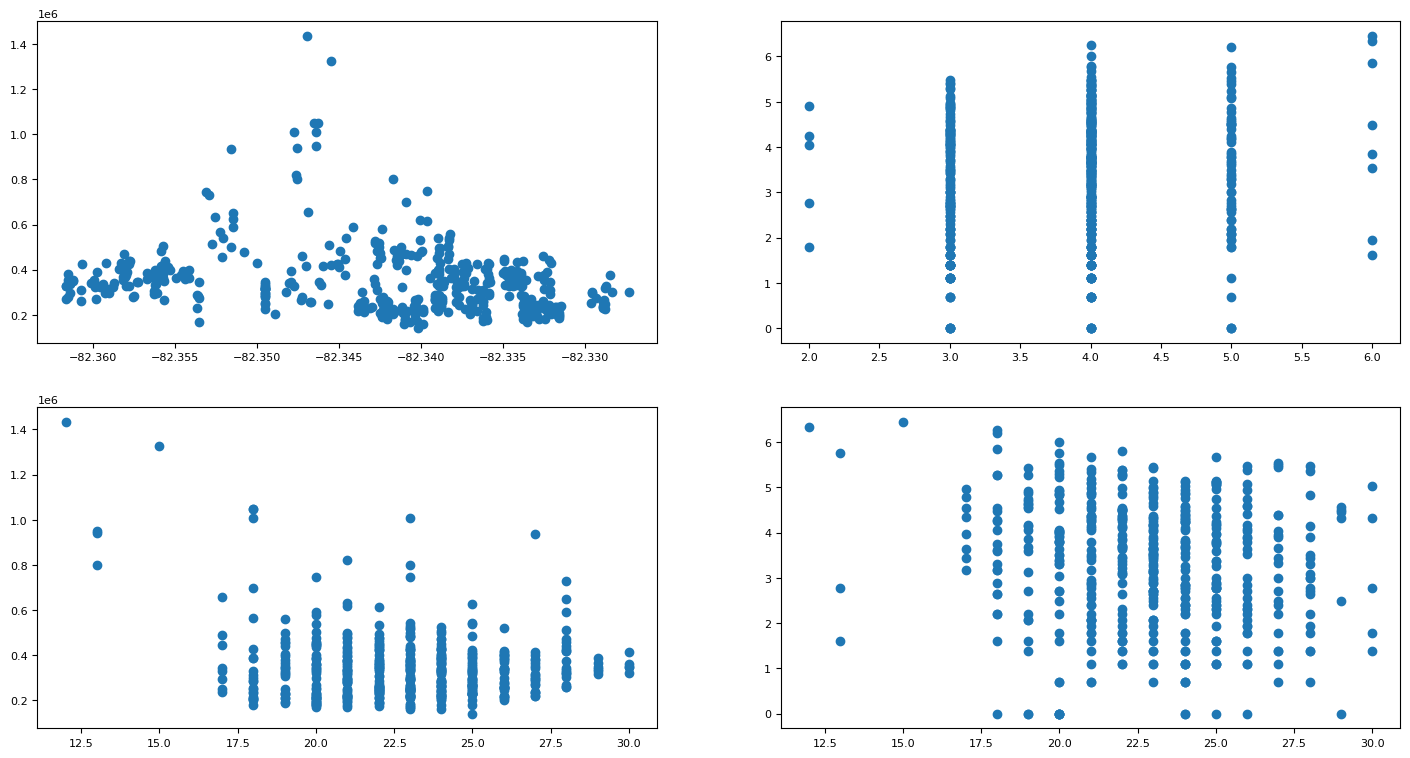

In [19]:
# scatter plots linearity
plt.rcParams.update({'font.size': 8})
fig, ((price_long, adom_bed),
      (price_age, adom_age)) = plt.subplots(nrows=2, ncols=2)

price_long.scatter(df['long'], df['pricesold'])
adom_bed.scatter(df['Beds'], df['log_adom'])
price_age.scatter(df['house_age'], df['pricesold'])
adom_age.scatter(df['house_age'], df['log_adom'])

fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

In [20]:
print(shapiro(df['long']), shapiro(df['house_age']), shapiro(df['pricesold']))
print(shapiro(df['Beds']), shapiro(df['house_age']), shapiro(df['log_adom']))

ShapiroResult(statistic=0.9246298902902466, pvalue=9.406267260526872e-15) ShapiroResult(statistic=0.983967671578804, pvalue=3.983847786882367e-05) ShapiroResult(statistic=0.7739297754102623, pvalue=3.7653481519038914e-25)
ShapiroResult(statistic=0.8213524185643972, pvalue=1.136172476710465e-22) ShapiroResult(statistic=0.983967671578804, pvalue=3.983847786882367e-05) ShapiroResult(statistic=0.9787593257838778, pvalue=1.916630275550103e-06)


In [21]:
print(bartlett(df['long'], df['house_age']))
print(bartlett(df['Beds'], df['house_age']))

BartlettResult(statistic=4880.110102024866, pvalue=0.0)
BartlettResult(statistic=769.6833639759009, pvalue=2.1066999654212837e-169)


In [22]:
df_ps = df[['long','house_age']]
vd = pd.DataFrame()
vd['feature'] = df_ps.columns
vd['VIF'] = [vif(df_ps.values, i) for i in range(len(df_ps.columns))]
print(vd)

     feature        VIF
0       long  59.308657
1  house_age  59.308657


In [23]:
df_ad = df[['Beds','house_age']]
vd = pd.DataFrame()
vd['feature'] = df_ad.columns
vd['VIF'] = [vif(df_ad.values, i) for i in range(len(df_ad.columns))]
print(vd)

     feature        VIF
0       Beds  17.555086
1  house_age  17.555086


In [29]:
print(durbin_watson(model3.resid))
print(durbin_watson(amodel3.resid))

0.5485102237830564
1.8684672215932223
